OPTUNA — BÚSQUEDA DE HIPERPARÁMETROS (50 trials)

⏳ Ejecutando optimización bayesiana...


  0%|          | 0/50 [00:00<?, ?it/s]


✅ Mejor RMSE CV: 1.0775

📊 Mejores hiperparámetros:
   n_estimators              374
   max_depth                 7
   learning_rate             0.021915023412663028
   subsample                 0.9287294878072603
   colsample_bytree          0.7841557962520868
   min_child_weight          8
   gamma                     0.7974772096959228
   reg_alpha                 0.5552369881389054
   reg_lambda                1.9159473505553417

📊 COMPARATIVA ANTES / DESPUÉS:
                               RMSE CV
  ------------------------------------
  XGBoost default (#17)         1.0711
  XGBoost optimizado (#19)      1.0775

  Mejora: -0.60%


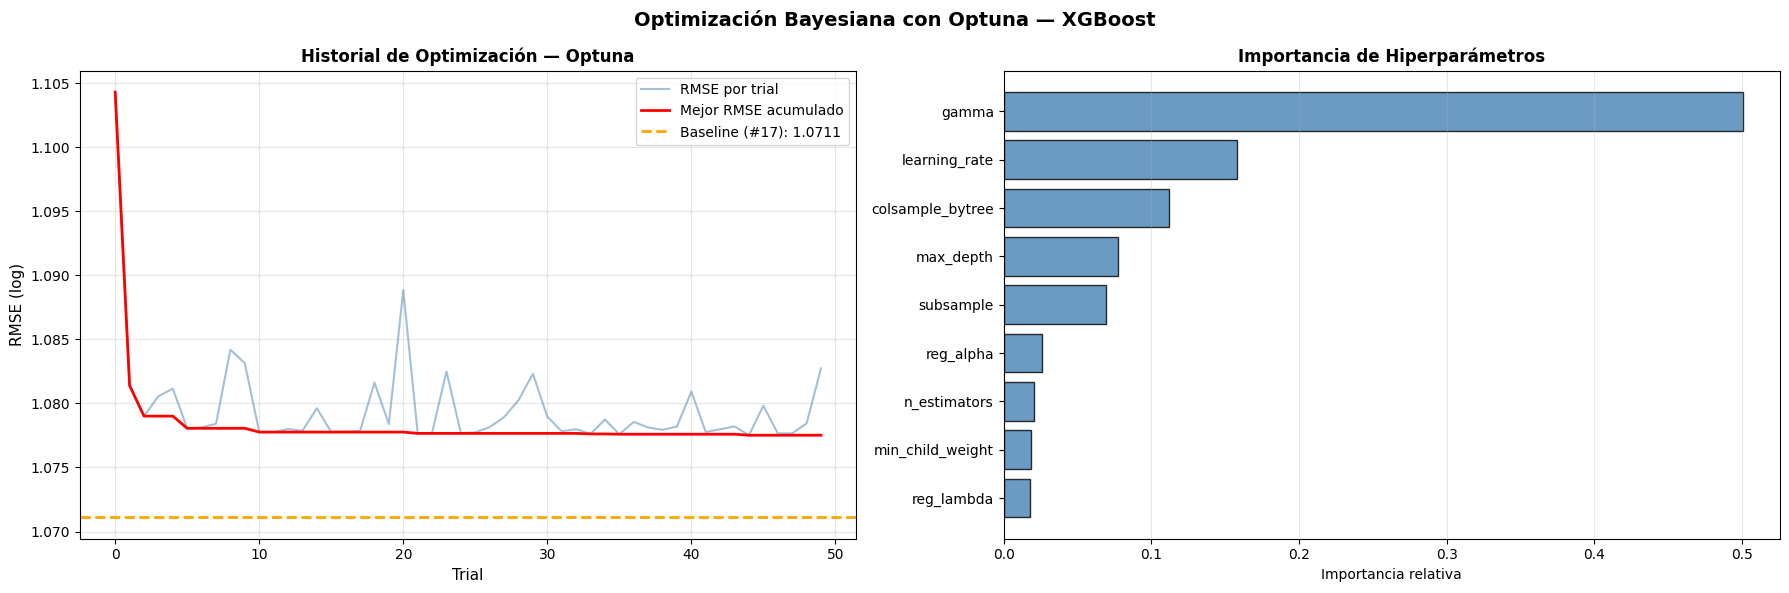


💾 Modelo optimizado guardado como optimized_model.pkl
💾 Hiperparámetros guardados en best_hyperparams.csv


In [1]:
# ==========================================================
# #19 — HYPERPARAMETER OPTIMIZATION CON OPTUNA
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import optuna
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances
)

from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import XGBRegressor

optuna.logging.set_verbosity(optuna.logging.WARNING)

# ============================================
# 1. CARGAR DATOS
# ============================================

df_model = pd.read_csv('../data/pet_adoption_model.csv')

FEATURES = ['AnimalType', 'Sex', 'IntakeType', 'IntakeCondition',
            'AgeInDays', 'AgeGroup', 'breed_type', 'Breed_grouped', 'Color_grouped']
TARGET   = 'TimeInShelterDays_log'

X = df_model[FEATURES].copy()
y = df_model[TARGET].copy()

# ============================================
# 2. PREPROCESADOR
# ============================================

ohe_cols       = ['AnimalType', 'Sex', 'IntakeType', 'IntakeCondition',
                  'breed_type', 'Breed_grouped', 'Color_grouped']
ordinal_col    = ['AgeGroup']
numerical_cols = ['AgeInDays']
orden_edad     = [['Cachorro (<6m)', 'Joven (6m-1a)', 'Adulto joven (1-3a)',
                   'Adulto (3-7a)', 'Senior (>7a)']]

preprocessor = ColumnTransformer(transformers=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ohe_cols),
    ("ord", OrdinalEncoder(categories=orden_edad,
                           handle_unknown="use_encoded_value",
                           unknown_value=-1), ordinal_col),
    ("num", StandardScaler(), numerical_cols)
], remainder='drop')

# ============================================
# 3. FUNCIÓN OBJETIVO PARA OPTUNA
# ============================================

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

def objective(trial):
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 100, 600),
        'max_depth':         trial.suggest_int('max_depth', 3, 10),
        'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample':         trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight':  trial.suggest_int('min_child_weight', 1, 10),
        'gamma':             trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha':         trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda':        trial.suggest_float('reg_lambda', 0.5, 2.0),
    }

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(
            **params,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ))
    ])

    scores = -cross_val_score(pipeline, X, y, cv=kf,
                               scoring=rmse_scorer, n_jobs=-1)
    return scores.mean()

# ============================================
# 4. EJECUTAR ESTUDIO OPTUNA
# ============================================

print("="*60)
print("OPTUNA — BÚSQUEDA DE HIPERPARÁMETROS (50 trials)")
print("="*60)
print("\n⏳ Ejecutando optimización bayesiana...")

study = optuna.create_study(
    direction='minimize',
    study_name='xgboost_pet_adoption',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# ============================================
# 5. MEJORES HIPERPARÁMETROS
# ============================================

best_params = study.best_params
best_rmse   = study.best_value

print(f"\n✅ Mejor RMSE CV: {best_rmse:.4f}")
print(f"\n📊 Mejores hiperparámetros:")
for k, v in best_params.items():
    print(f"   {k:<25} {v}")

# Comparativa antes/después
rmse_antes = 1.0711   # del #17
print(f"\n📊 COMPARATIVA ANTES / DESPUÉS:")
print(f"  {'':25} {'RMSE CV':>10}")
print(f"  {'-'*36}")
print(f"  {'XGBoost default (#17)':<25} {rmse_antes:>10.4f}")
print(f"  {'XGBoost optimizado (#19)':<25} {best_rmse:>10.4f}")
mejora = (rmse_antes - best_rmse) / rmse_antes * 100
print(f"\n  Mejora: {mejora:.2f}%")

# ============================================
# 6. ENTRENAR MODELO OPTIMIZADO FINAL
# ============================================

best_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        **best_params,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ))
])

best_pipeline.fit(X, y)

# ============================================
# 7. GRÁFICOS DE OPTUNA
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Historial de optimización
trials_rmse = [t.value for t in study.trials]
axes[0].plot(trials_rmse, color='steelblue', alpha=0.5, label='RMSE por trial')
best_so_far = pd.Series(trials_rmse).cummin()
axes[0].plot(best_so_far, color='red', linewidth=2, label='Mejor RMSE acumulado')
axes[0].axhline(rmse_antes, color='orange', linestyle='--',
                linewidth=2, label=f'Baseline (#17): {rmse_antes:.4f}')
axes[0].set_xlabel('Trial', fontsize=11)
axes[0].set_ylabel('RMSE (log)', fontsize=11)
axes[0].set_title('Historial de Optimización — Optuna', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Importancia de hiperparámetros
importances = optuna.importance.get_param_importances(study)
params_names = list(importances.keys())
params_vals  = list(importances.values())

axes[1].barh(params_names[::-1], params_vals[::-1],
             color='steelblue', edgecolor='black', alpha=0.8)
axes[1].set_title('Importancia de Hiperparámetros', fontweight='bold')
axes[1].set_xlabel('Importancia relativa')
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle('Optimización Bayesiana con Optuna — XGBoost',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================
# 8. GUARDAR MODELO OPTIMIZADO
# ============================================

joblib.dump(best_pipeline, '../models/optimized_model.pkl')
print(f"\n💾 Modelo optimizado guardado como optimized_model.pkl")

# Guardar también los mejores hiperparámetros
pd.DataFrame([best_params]).to_csv('../data/best_hyperparams.csv', index=False)
print(f"💾 Hiperparámetros guardados en best_hyperparams.csv")